In [74]:
import scipy.io
import numpy as np
from sklearn.preprocessing import scale, LabelBinarizer
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout, MaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD


In [79]:
def load_dataset():
    fname = "data/train_4.mat"
    train_mat = scipy.io.loadmat(fname)
    fname = "data/test_4.mat"
    test_mat = scipy.io.loadmat(fname)

    dataset = train_mat.get("feat") # or use emg_data_train for using all 16 gestures
    x = []
    y = []
    for i, entry in np.ndenumerate(dataset):
        # i is a tuple of (row, column)
        # save readings into data array
        x.append(dataset[i[0],i[1]])
        # gesture class is put into labels array
        y.append(i[1])
    trainX = np.array(x)
    trainy = np.array(y)

    # similarly do for the test data
    dataset = test_mat.get("feat") # or use emg_data_test for using all 16 gestures
    x = []
    y = []
    for i, entry in np.ndenumerate(dataset):
        x.append(dataset[i[0],i[1]])
        y.append(i[1])
    testX = np.array(x)
    testy = np.array(y)

    print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
    print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
    # convert the labels from integers/categories to vectors 
    lb = LabelBinarizer()
    trainy = lb.fit_transform(trainy)   # fit_transform = find all unique class labels + transform into one-hot encoded labels
    print(lb.classes_)
    testy = lb.transform(testy)         # transform = perform the one-hot encoding (unique class labels already found)

    return trainX, trainy, testX, testy

In [80]:
trainX, trainY, testX, testY = load_dataset()

Train: X=(420, 233, 36), y=(420,)
Test: X=(96, 233, 36), y=(96,)
[0 1 2 3]


Build model

In [71]:
# define cnn model
def define_model_conv2d(n_classes):
	model = Sequential()

	model.add(Conv2D(32, kernel_size=(3,4), activation='relu', input_shape=(36, 233, 1)))

	# model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
	# model.add(Dropout(0.15))
	model.add(MaxPooling2D(pool_size = 2, strides=1))

	# model.add(Conv2D(32, kernel_size=(2,1)))

	model.add(Conv2D(64, kernel_size=(1,3), strides=(1,2), padding='same'))
	# model.add(Dropout(0.15))
	model.add(MaxPooling2D(pool_size = 2, strides=(2,2)))

	model.add(Conv2D(kernel_size=(2,2), strides=1, filters=128, padding='same', activation='relu', name='layer_conv8'))
	# model.add(Dropout(0.15))
	model.add(Flatten())

	# Stage 7
	# model.add(Dense(units = 512, activation='relu'))
	# model.add(Dropout(0.25))

	# Stage 8
	model.add(Dense(units = 128, activation='relu'))
	# model.add(Dropout(0.25))

	# Stage 9
	model.add(Dense(units = 64, activation='relu'))
	# model.add(Dropout(0.25))

	model.add(Dense(n_classes, activation='softmax'))
	# compile model
	# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
	sgd = SGD(learning_rate=0.01,  momentum=0.9, nesterov=False)
	model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
	return model

In [81]:
def define_model_conv1d(n_classes):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(233, 36)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model


In [83]:
model = define_model_conv1d(n_classes=4)
history = model.fit(trainX, trainY, epochs=50, validation_data=(testX, testY))

Epoch 1/50
14/14 [==============================] - 4s 124ms/step - loss: 1.8662 - accuracy: 0.3238 - val_loss: 1.2135 - val_accuracy: 0.4479
Epoch 2/50
14/14 [==============================] - 1s 49ms/step - loss: 1.0586 - accuracy: 0.5643 - val_loss: 1.0066 - val_accuracy: 0.5000
Epoch 3/50
14/14 [==============================] - 1s 43ms/step - loss: 0.9028 - accuracy: 0.6048 - val_loss: 1.0244 - val_accuracy: 0.5729
Epoch 4/50
14/14 [==============================] - 1s 41ms/step - loss: 0.8919 - accuracy: 0.6571 - val_loss: 0.9616 - val_accuracy: 0.5521
Epoch 5/50
14/14 [==============================] - 1s 41ms/step - loss: 0.7484 - accuracy: 0.6810 - val_loss: 0.9800 - val_accuracy: 0.5625
Epoch 6/50
14/14 [==============================] - 1s 54ms/step - loss: 0.6762 - accuracy: 0.7167 - val_loss: 1.0594 - val_accuracy: 0.5417
Epoch 7/50
14/14 [==============================] - 1s 37ms/step - loss: 0.7037 - accuracy: 0.6952 - val_loss: 1.0570 - val_accuracy: 0.5938
Epoch 8/50
1

In [87]:
test_loss, test_acc = model.evaluate(testX, testY)

3/3 [==============================] - 0s 13ms/step - loss: 2.6342 - accuracy: 0.5729


In [47]:
def evaluate_model(dataX, dataY, n_classes, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model(n_classes)
        # select rows for train and test
        trX, trY, teX, teY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trX, trY, epochs=50, batch_size=32, validation_data=(teX, teY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(teX, teY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [48]:
scores, histories = evaluate_model(trainX, trainY, n_classes=4, n_folds=10)
histories

KeyboardInterrupt: 

In [ ]:
histories[0].history

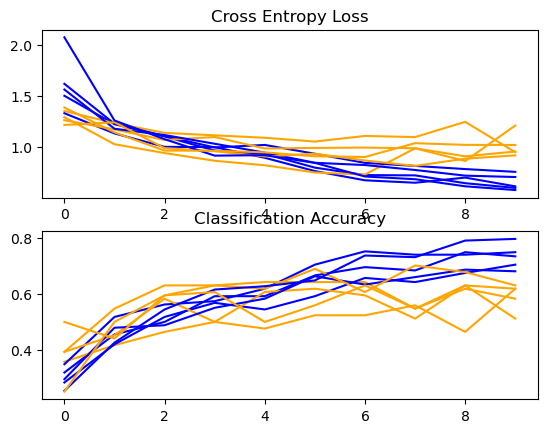

In [22]:
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

summarize_diagnostics(histories)